In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import time
import string
import warnings
import spacy
from tqdm.notebook import tqdm_notebook

# for all NLP related operations on text
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.classify import NaiveBayesClassifier
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# To identify the sentiment of text
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from textblob.np_extractors import ConllExtractor

from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.pipeline import make_pipeline
from nltk.tokenize import RegexpTokenizer

# ignoring all the warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# downloading stopwords corpus
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('movie_reviews')
nltk.download('punkt')
nltk.download('conll2000')
nltk.download('brown')
stopwords = set(stopwords.words("english"))

# for showing all the plots inline
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chakri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chakri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\chakri\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\chakri\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\chakri\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chakri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt 

In [2]:
# load the dataset
tweets=pd.read_csv("C:\\Users\\chakri\\Downloads\\Elon_musk.csv", encoding='latin1')
tweets.drop(['Unnamed: 0'],inplace=True,axis=1)
tweets.rename({'Text':'Tweets'},axis=1,inplace=True)
tweets

,Tweets
0,@kunalb11 Im an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...
2,@joerogan @Spotify Great interview!
3,@gtera27 Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...
...,...
1994,"@flcnhvy True, it sounds so surreal, but the n..."
1995,@PPathole Make sure to read ur terms &amp; con...
1996,@TeslaGong @PPathole Samwise Gamgee
1997,@PPathole Altho Dumb and Dumber is <U+0001F525...


# Data Exploration

Number of words

In [3]:
tweets['word_count'] = tweets['Tweets'].apply(lambda x: len(str(x).split(" ")))
tweets[['Tweets','word_count']].head()

,Tweets,word_count
0,@kunalb11 Im an alien,4
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,13
2,@joerogan @Spotify Great interview!,4
3,@gtera27 Doge is underestimated,4
4,@teslacn Congratulations Tesla China for amazi...,17


Number of characters

In [4]:
tweets['char_count'] = tweets['Tweets'].str.len() ## this also includes spaces
tweets[['Tweets','char_count']].head()

,Tweets,char_count
0,@kunalb11 Im an alien,22
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,82
2,@joerogan @Spotify Great interview!,35
3,@gtera27 Doge is underestimated,31
4,@teslacn Congratulations Tesla China for amazi...,104


Average Word Length

In [5]:
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

tweets['avg_word'] = tweets['Tweets'].apply(lambda x: avg_word(x))
tweets[['Tweets','avg_word']].head()

,Tweets,avg_word
0,@kunalb11 Im an alien,4.750000
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,5.384615
2,@joerogan @Spotify Great interview!,8.000000
3,@gtera27 Doge is underestimated,7.000000
4,@teslacn Congratulations Tesla China for amazi...,5.176471


Number of stopwords

In [6]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

tweets['stopwords'] = tweets['Tweets'].apply(lambda x: len([x for x in x.split() if x in stop]))
tweets[['Tweets','stopwords']].head()

,Tweets,stopwords
0,@kunalb11 Im an alien,1
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,4
2,@joerogan @Spotify Great interview!,0
3,@gtera27 Doge is underestimated,1
4,@teslacn Congratulations Tesla China for amazi...,5


Number of special characters

In [7]:
tweets['hashtags'] = tweets['Tweets'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
tweets[['Tweets','hashtags']].head()

,Tweets,hashtags
0,@kunalb11 Im an alien,0
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,0
2,@joerogan @Spotify Great interview!,0
3,@gtera27 Doge is underestimated,0
4,@teslacn Congratulations Tesla China for amazi...,0


Number of numerics

In [8]:
tweets['numerics'] = tweets['Tweets'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
tweets[['Tweets','numerics']].head()

,Tweets,numerics
0,@kunalb11 Im an alien,0
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,0
2,@joerogan @Spotify Great interview!,0
3,@gtera27 Doge is underestimated,0
4,@teslacn Congratulations Tesla China for amazi...,0


Number of Uppercase words

In [9]:
tweets['upper'] = tweets['Tweets'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
tweets[['Tweets','upper']].head()


,Tweets,upper
0,@kunalb11 Im an alien,0
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,1
2,@joerogan @Spotify Great interview!,0
3,@gtera27 Doge is underestimated,0
4,@teslacn Congratulations Tesla China for amazi...,0


Number of Rare Words

In [10]:
freq = pd.Series(' '.join(tweets['Tweets']).split()).value_counts()[-10:]
freq

N3                         1
lab                        1
(N1                        1
detection                  1
Lab                        1
https://t.co/K77wXQ11yt    1
dicey                      1
accurate,                  1
thinks                     1
28                         1
dtype: int64

Percentage of Links attached in the tweets

In [11]:
tweets.Tweets.str.contains('https://').value_counts() / len(tweets)


False    0.678339
True     0.321661
Name: Tweets, dtype: float64

A quarter of Musk tweets include URLs..

Percentage of User Tags in the tweets

In [12]:
tweets.Tweets.str.contains('@').value_counts() / len(tweets)

True     0.83942
False    0.16058
Name: Tweets, dtype: float64

Total number of Tweets in the available DataFrame

In [13]:
# Total tweets
print('Total tweets this period:', len(tweets.index), '\n')

Total tweets this period: 1999 



# Spelling correction

In [14]:
from textblob import TextBlob
tweets['Tweets'][:5].apply(lambda x: str(TextBlob(x).correct()))

0                               @kunalb11 Im an alien
1    @ID_AA_Carmack May tracing on Cyberpunk with H...
2                   @joerogan @Notify Great interview!
3                       @gtera27 One is underestimated
4    @teslacn Congratulations Cela China for amazin...
Name: Tweets, dtype: object

N-grams


In [15]:
TextBlob(tweets['Tweets'][3]).ngrams(1)


[WordList(['gtera27']),
 WordList(['Doge']),
 WordList(['is']),
 WordList(['underestimated'])]

In [16]:
TextBlob(tweets['Tweets'][2]).ngrams(2)

[WordList(['joerogan', 'Spotify']),
 WordList(['Spotify', 'Great']),
 WordList(['Great', 'interview'])]

In [17]:
TextBlob(tweets['Tweets'][4]).ngrams(3)

[WordList(['teslacn', 'Congratulations', 'Tesla']),
 WordList(['Congratulations', 'Tesla', 'China']),
 WordList(['Tesla', 'China', 'for']),
 WordList(['China', 'for', 'amazing']),
 WordList(['for', 'amazing', 'execution']),
 WordList(['amazing', 'execution', 'last']),
 WordList(['execution', 'last', 'year']),
 WordList(['last', 'year', 'Now']),
 WordList(['year', 'Now', 'on']),
 WordList(['Now', 'on', 'to']),
 WordList(['on', 'to', 'the']),
 WordList(['to', 'the', 'next']),
 WordList(['the', 'next', 'for']),
 WordList(['next', 'for', 'even']),
 WordList(['for', 'even', 'more'])]

# Data Visualization

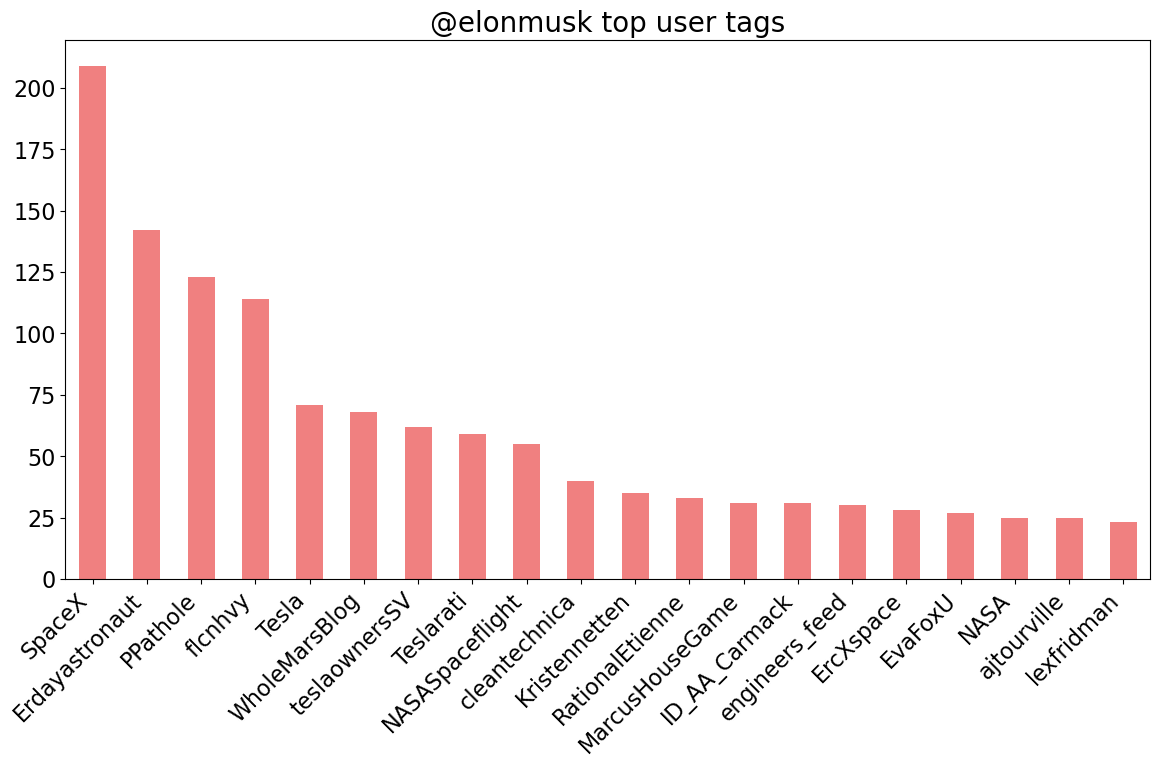

In [18]:
import itertools

c = list(
itertools.chain(
    *tweets.Tweets.map(lambda t: [handle.replace(":", "")[1:] for handle in t.split(" ") 
                            if '@' in handle.replace(":", "")]).tolist())
)

pd.Series(c).value_counts().head(20).plot.bar(
    figsize=(14, 7), fontsize=16, color='lightcoral'
)
plt.gca().set_title('@elonmusk top user tags', fontsize=20)
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=45, ha='right', fontsize=16)
pass

# BasicText Preprocessing

In [19]:
tweets=[Text.strip() for Text in tweets.Tweets] # remove both the leading and the trailing characters
tweets=[Text for Text in tweets if Text] # removes empty strings, because they are considered in Python as False
tweets[0:10]

['@kunalb11 I\x92m an alien',
 '@ID_AA_Carmack Ray tracing on Cyberpunk with HDR is next-level. Have you tried it?',
 '@joerogan @Spotify Great interview!',
 '@gtera27 Doge is underestimated',
 '@teslacn Congratulations Tesla China for amazing execution last year. Now on to the next for even more!!',
 'Happy New Year of the Ox! https://t.co/9WFKMYu2oj',
 'Frodo was the underdoge,\nAll thought he would fail,\nHimself most of all. https://t.co/zGxJFDzzrM',
 '@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :)',
 '@flcnhvy @anonyx10 Indeed! Tweets definitely do not represent real-world time allocation.',
 'The most entertaining outcome is the most likely']

In [20]:
# Joining the list into one string/text
tweets_text=' '.join(tweets)
tweets_text[:1000]

'@kunalb11 I\x92m an alien @ID_AA_Carmack Ray tracing on Cyberpunk with HDR is next-level. Have you tried it? @joerogan @Spotify Great interview! @gtera27 Doge is underestimated @teslacn Congratulations Tesla China for amazing execution last year. Now on to the next for even more!! Happy New Year of the Ox! https://t.co/9WFKMYu2oj Frodo was the underdoge,\nAll thought he would fail,\nHimself most of all. https://t.co/zGxJFDzzrM @OwenSparks_ @flcnhvy @anonyx10 Haha thanks :) @flcnhvy @anonyx10 Indeed! Tweets definitely do not represent real-world time allocation. The most entertaining outcome is the most likely @GiveDirectly Just sent some Just agree to do Clubhouse with @kanyewest https://t.co/3rWE9uHSTS @geoffkeighley @UnrealEngine It\x92s getting real Bought some Dogecoin for lil X, so he can be a toddler hodler @JoshManMode He definitely has issues, but the sentencing seems a bit high @freewalletorg Thanks for fixing @freewalletorg Please unlock my account @AstroJordy <U+0001F923><U

In [21]:
# remove Twitter username handles from a given twitter text. (Removes @usernames)
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer(strip_handles=True)
tweets_tokens=tknzr.tokenize(tweets_text)
print(tweets_tokens[:100])

['I', '\x92', 'm', 'an', 'alien', 'Ray', 'tracing', 'on', 'Cyberpunk', 'with', 'HDR', 'is', 'next-level', '.', 'Have', 'you', 'tried', 'it', '?', 'Great', 'interview', '!', 'Doge', 'is', 'underestimated', 'Congratulations', 'Tesla', 'China', 'for', 'amazing', 'execution', 'last', 'year', '.', 'Now', 'on', 'to', 'the', 'next', 'for', 'even', 'more', '!', '!', 'Happy', 'New', 'Year', 'of', 'the', 'Ox', '!', 'https://t.co/9WFKMYu2oj', 'Frodo', 'was', 'the', 'underdoge', ',', 'All', 'thought', 'he', 'would', 'fail', ',', 'Himself', 'most', 'of', 'all', '.', 'https://t.co/zGxJFDzzrM', 'Haha', 'thanks', ':)', 'Indeed', '!', 'Tweets', 'definitely', 'do', 'not', 'represent', 'real-world', 'time', 'allocation', '.', 'The', 'most', 'entertaining', 'outcome', 'is', 'the', 'most', 'likely', 'Just', 'sent', 'some', 'Just', 'agree', 'to', 'do', 'Clubhouse', 'with']


In [22]:
# Again Joining the list into one string/text
tweets_tokens_text=' '.join(tweets_tokens)
tweets_tokens_text[:1000]

'I \x92 m an alien Ray tracing on Cyberpunk with HDR is next-level . Have you tried it ? Great interview ! Doge is underestimated Congratulations Tesla China for amazing execution last year . Now on to the next for even more ! ! Happy New Year of the Ox ! https://t.co/9WFKMYu2oj Frodo was the underdoge , All thought he would fail , Himself most of all . https://t.co/zGxJFDzzrM Haha thanks :) Indeed ! Tweets definitely do not represent real-world time allocation . The most entertaining outcome is the most likely Just sent some Just agree to do Clubhouse with https://t.co/3rWE9uHSTS It \x92 s getting real Bought some Dogecoin for lil X , so he can be a toddler hodler He definitely has issues , but the sentencing seems a bit high Thanks for fixing Please unlock my account <U+0001F923> <U+0001F923> This is true power haha https://t.co/Fc9uhQSd7O Any crypto wallet that won \x92 t give you your private keys should be avoided at all costs Your app sucks RT : NASA has selected Falcon Heavy to 

In [23]:
# Remove Punctuations 
no_punc_text=tweets_tokens_text.translate(str.maketrans('','',string.punctuation))
no_punc_text[:1000]

'I \x92 m an alien Ray tracing on Cyberpunk with HDR is nextlevel  Have you tried it  Great interview  Doge is underestimated Congratulations Tesla China for amazing execution last year  Now on to the next for even more   Happy New Year of the Ox  httpstco9WFKMYu2oj Frodo was the underdoge  All thought he would fail  Himself most of all  httpstcozGxJFDzzrM Haha thanks  Indeed  Tweets definitely do not represent realworld time allocation  The most entertaining outcome is the most likely Just sent some Just agree to do Clubhouse with httpstco3rWE9uHSTS It \x92 s getting real Bought some Dogecoin for lil X  so he can be a toddler hodler He definitely has issues  but the sentencing seems a bit high Thanks for fixing Please unlock my account U0001F923 U0001F923 This is true power haha httpstcoFc9uhQSd7O Any crypto wallet that won \x92 t give you your private keys should be avoided at all costs Your app sucks RT  NASA has selected Falcon Heavy to launch the first two elements of the lunar Ga

In [24]:
# remove https or url within text
import re
no_url_text=re.sub(r'http\S+', '', no_punc_text)
no_url_text[:1000]

'I \x92 m an alien Ray tracing on Cyberpunk with HDR is nextlevel  Have you tried it  Great interview  Doge is underestimated Congratulations Tesla China for amazing execution last year  Now on to the next for even more   Happy New Year of the Ox   Frodo was the underdoge  All thought he would fail  Himself most of all   Haha thanks  Indeed  Tweets definitely do not represent realworld time allocation  The most entertaining outcome is the most likely Just sent some Just agree to do Clubhouse with  It \x92 s getting real Bought some Dogecoin for lil X  so he can be a toddler hodler He definitely has issues  but the sentencing seems a bit high Thanks for fixing Please unlock my account U0001F923 U0001F923 This is true power haha  Any crypto wallet that won \x92 t give you your private keys should be avoided at all costs Your app sucks RT  NASA has selected Falcon Heavy to launch the first two elements of the lunar Gateway together on one mission   Yes Once we can predict cash flow reason

In [25]:
import nltk.data
from nltk.tokenize import word_tokenize
text_tokens=word_tokenize(no_url_text)
print(text_tokens[:100])

['I', '\x92', 'm', 'an', 'alien', 'Ray', 'tracing', 'on', 'Cyberpunk', 'with', 'HDR', 'is', 'nextlevel', 'Have', 'you', 'tried', 'it', 'Great', 'interview', 'Doge', 'is', 'underestimated', 'Congratulations', 'Tesla', 'China', 'for', 'amazing', 'execution', 'last', 'year', 'Now', 'on', 'to', 'the', 'next', 'for', 'even', 'more', 'Happy', 'New', 'Year', 'of', 'the', 'Ox', 'Frodo', 'was', 'the', 'underdoge', 'All', 'thought', 'he', 'would', 'fail', 'Himself', 'most', 'of', 'all', 'Haha', 'thanks', 'Indeed', 'Tweets', 'definitely', 'do', 'not', 'represent', 'realworld', 'time', 'allocation', 'The', 'most', 'entertaining', 'outcome', 'is', 'the', 'most', 'likely', 'Just', 'sent', 'some', 'Just', 'agree', 'to', 'do', 'Clubhouse', 'with', 'It', '\x92', 's', 'getting', 'real', 'Bought', 'some', 'Dogecoin', 'for', 'lil', 'X', 'so', 'he', 'can', 'be']


In [26]:
# Tokens count
len(text_tokens)

17847

In [27]:
# Remove Stopwords
from nltk.corpus import stopwords
my_stop_words=stopwords.words('english')

sw_list = ['\x92','rt','ye','yeah','haha','Yes','U0001F923','I','U0001F3B6','U0001F5A4']
my_stop_words.extend(sw_list)

no_stop_tokens=[word for word in text_tokens if not word in my_stop_words]
print(no_stop_tokens[:100])

['alien', 'Ray', 'tracing', 'Cyberpunk', 'HDR', 'nextlevel', 'Have', 'tried', 'Great', 'interview', 'Doge', 'underestimated', 'Congratulations', 'Tesla', 'China', 'amazing', 'execution', 'last', 'year', 'Now', 'next', 'even', 'Happy', 'New', 'Year', 'Ox', 'Frodo', 'underdoge', 'All', 'thought', 'would', 'fail', 'Himself', 'Haha', 'thanks', 'Indeed', 'Tweets', 'definitely', 'represent', 'realworld', 'time', 'allocation', 'The', 'entertaining', 'outcome', 'likely', 'Just', 'sent', 'Just', 'agree', 'Clubhouse', 'It', 'getting', 'real', 'Bought', 'Dogecoin', 'lil', 'X', 'toddler', 'hodler', 'He', 'definitely', 'issues', 'sentencing', 'seems', 'bit', 'high', 'Thanks', 'fixing', 'Please', 'unlock', 'account', 'This', 'true', 'power', 'Any', 'crypto', 'wallet', 'give', 'private', 'keys', 'avoided', 'costs', 'Your', 'app', 'sucks', 'RT', 'NASA', 'selected', 'Falcon', 'Heavy', 'launch', 'first', 'two', 'elements', 'lunar', 'Gateway', 'together', 'one', 'mission']


In [28]:
# Making the Text in Lowercase
lower_words=[Text.lower() for Text in no_stop_tokens]
print(lower_words[:100])

['alien', 'ray', 'tracing', 'cyberpunk', 'hdr', 'nextlevel', 'have', 'tried', 'great', 'interview', 'doge', 'underestimated', 'congratulations', 'tesla', 'china', 'amazing', 'execution', 'last', 'year', 'now', 'next', 'even', 'happy', 'new', 'year', 'ox', 'frodo', 'underdoge', 'all', 'thought', 'would', 'fail', 'himself', 'haha', 'thanks', 'indeed', 'tweets', 'definitely', 'represent', 'realworld', 'time', 'allocation', 'the', 'entertaining', 'outcome', 'likely', 'just', 'sent', 'just', 'agree', 'clubhouse', 'it', 'getting', 'real', 'bought', 'dogecoin', 'lil', 'x', 'toddler', 'hodler', 'he', 'definitely', 'issues', 'sentencing', 'seems', 'bit', 'high', 'thanks', 'fixing', 'please', 'unlock', 'account', 'this', 'true', 'power', 'any', 'crypto', 'wallet', 'give', 'private', 'keys', 'avoided', 'costs', 'your', 'app', 'sucks', 'rt', 'nasa', 'selected', 'falcon', 'heavy', 'launch', 'first', 'two', 'elements', 'lunar', 'gateway', 'together', 'one', 'mission']


In [29]:
# Stemming 
from nltk.stem import PorterStemmer
ps=PorterStemmer()
stemmed_tokens=[ps.stem(word) for word in lower_words]
print(stemmed_tokens[:100])

['alien', 'ray', 'trace', 'cyberpunk', 'hdr', 'nextlevel', 'have', 'tri', 'great', 'interview', 'doge', 'underestim', 'congratul', 'tesla', 'china', 'amaz', 'execut', 'last', 'year', 'now', 'next', 'even', 'happi', 'new', 'year', 'ox', 'frodo', 'underdog', 'all', 'thought', 'would', 'fail', 'himself', 'haha', 'thank', 'inde', 'tweet', 'definit', 'repres', 'realworld', 'time', 'alloc', 'the', 'entertain', 'outcom', 'like', 'just', 'sent', 'just', 'agre', 'clubhous', 'it', 'get', 'real', 'bought', 'dogecoin', 'lil', 'x', 'toddler', 'hodler', 'he', 'definit', 'issu', 'sentenc', 'seem', 'bit', 'high', 'thank', 'fix', 'pleas', 'unlock', 'account', 'thi', 'true', 'power', 'ani', 'crypto', 'wallet', 'give', 'privat', 'key', 'avoid', 'cost', 'your', 'app', 'suck', 'rt', 'nasa', 'select', 'falcon', 'heavi', 'launch', 'first', 'two', 'element', 'lunar', 'gateway', 'togeth', 'one', 'mission']


In [30]:
# Lemmatization
nlp=spacy.load('en_core_web_sm')
doc=nlp(' '.join(lower_words))
print(doc[:100])

alien ray tracing cyberpunk hdr nextlevel have tried great interview doge underestimated congratulations tesla china amazing execution last year now next even happy new year ox frodo underdoge all thought would fail himself haha thanks indeed tweets definitely represent realworld time allocation the entertaining outcome likely just sent just agree clubhouse it getting real bought dogecoin lil x toddler hodler he definitely issues sentencing seems bit high thanks fixing please unlock account this true power any crypto wallet give private keys avoided costs your app sucks rt nasa selected falcon heavy launch first two elements lunar gateway together one mission


In [31]:
lemmas=[token.lemma_ for token in doc]
print(lemmas[:100])

['alien', 'ray', 'trace', 'cyberpunk', 'hdr', 'nextlevel', 'have', 'try', 'great', 'interview', 'doge', 'underestimate', 'congratulation', 'tesla', 'china', 'amazing', 'execution', 'last', 'year', 'now', 'next', 'even', 'happy', 'new', 'year', 'ox', 'frodo', 'underdoge', 'all', 'thought', 'would', 'fail', 'himself', 'haha', 'thank', 'indeed', 'tweet', 'definitely', 'represent', 'realworld', 'time', 'allocation', 'the', 'entertaining', 'outcome', 'likely', 'just', 'send', 'just', 'agree', 'clubhouse', 'it', 'get', 'real', 'buy', 'dogecoin', 'lil', 'x', 'toddler', 'hodler', 'he', 'definitely', 'issue', 'sentencing', 'seem', 'bit', 'high', 'thank', 'fix', 'please', 'unlock', 'account', 'this', 'true', 'power', 'any', 'crypto', 'wallet', 'give', 'private', 'key', 'avoid', 'cost', 'your', 'app', 'suck', 'rt', 'nasa', 'select', 'falcon', 'heavy', 'launch', 'first', 'two', 'element', 'lunar', 'gateway', 'together', 'one', 'mission']


In [32]:
clean_tweets=' '.join(lemmas)
clean_tweets[:1000]

'alien ray trace cyberpunk hdr nextlevel have try great interview doge underestimate congratulation tesla china amazing execution last year now next even happy new year ox frodo underdoge all thought would fail himself haha thank indeed tweet definitely represent realworld time allocation the entertaining outcome likely just send just agree clubhouse it get real buy dogecoin lil x toddler hodler he definitely issue sentencing seem bit high thank fix please unlock account this true power any crypto wallet give private key avoid cost your app suck rt nasa select falcon heavy launch first two element lunar gateway together one mission once predict cash flow reasonably well starlink ipo starlink staggeringly difficult technical economic endeavor however spacex need pass deep chasm negative cash flow next year low cost per ton carbon sequester net value product make must scalable g it mean price country only difference taxis ship this intend earth may idea apply mar xprize team manage 100 m

# Generate Word Cloud

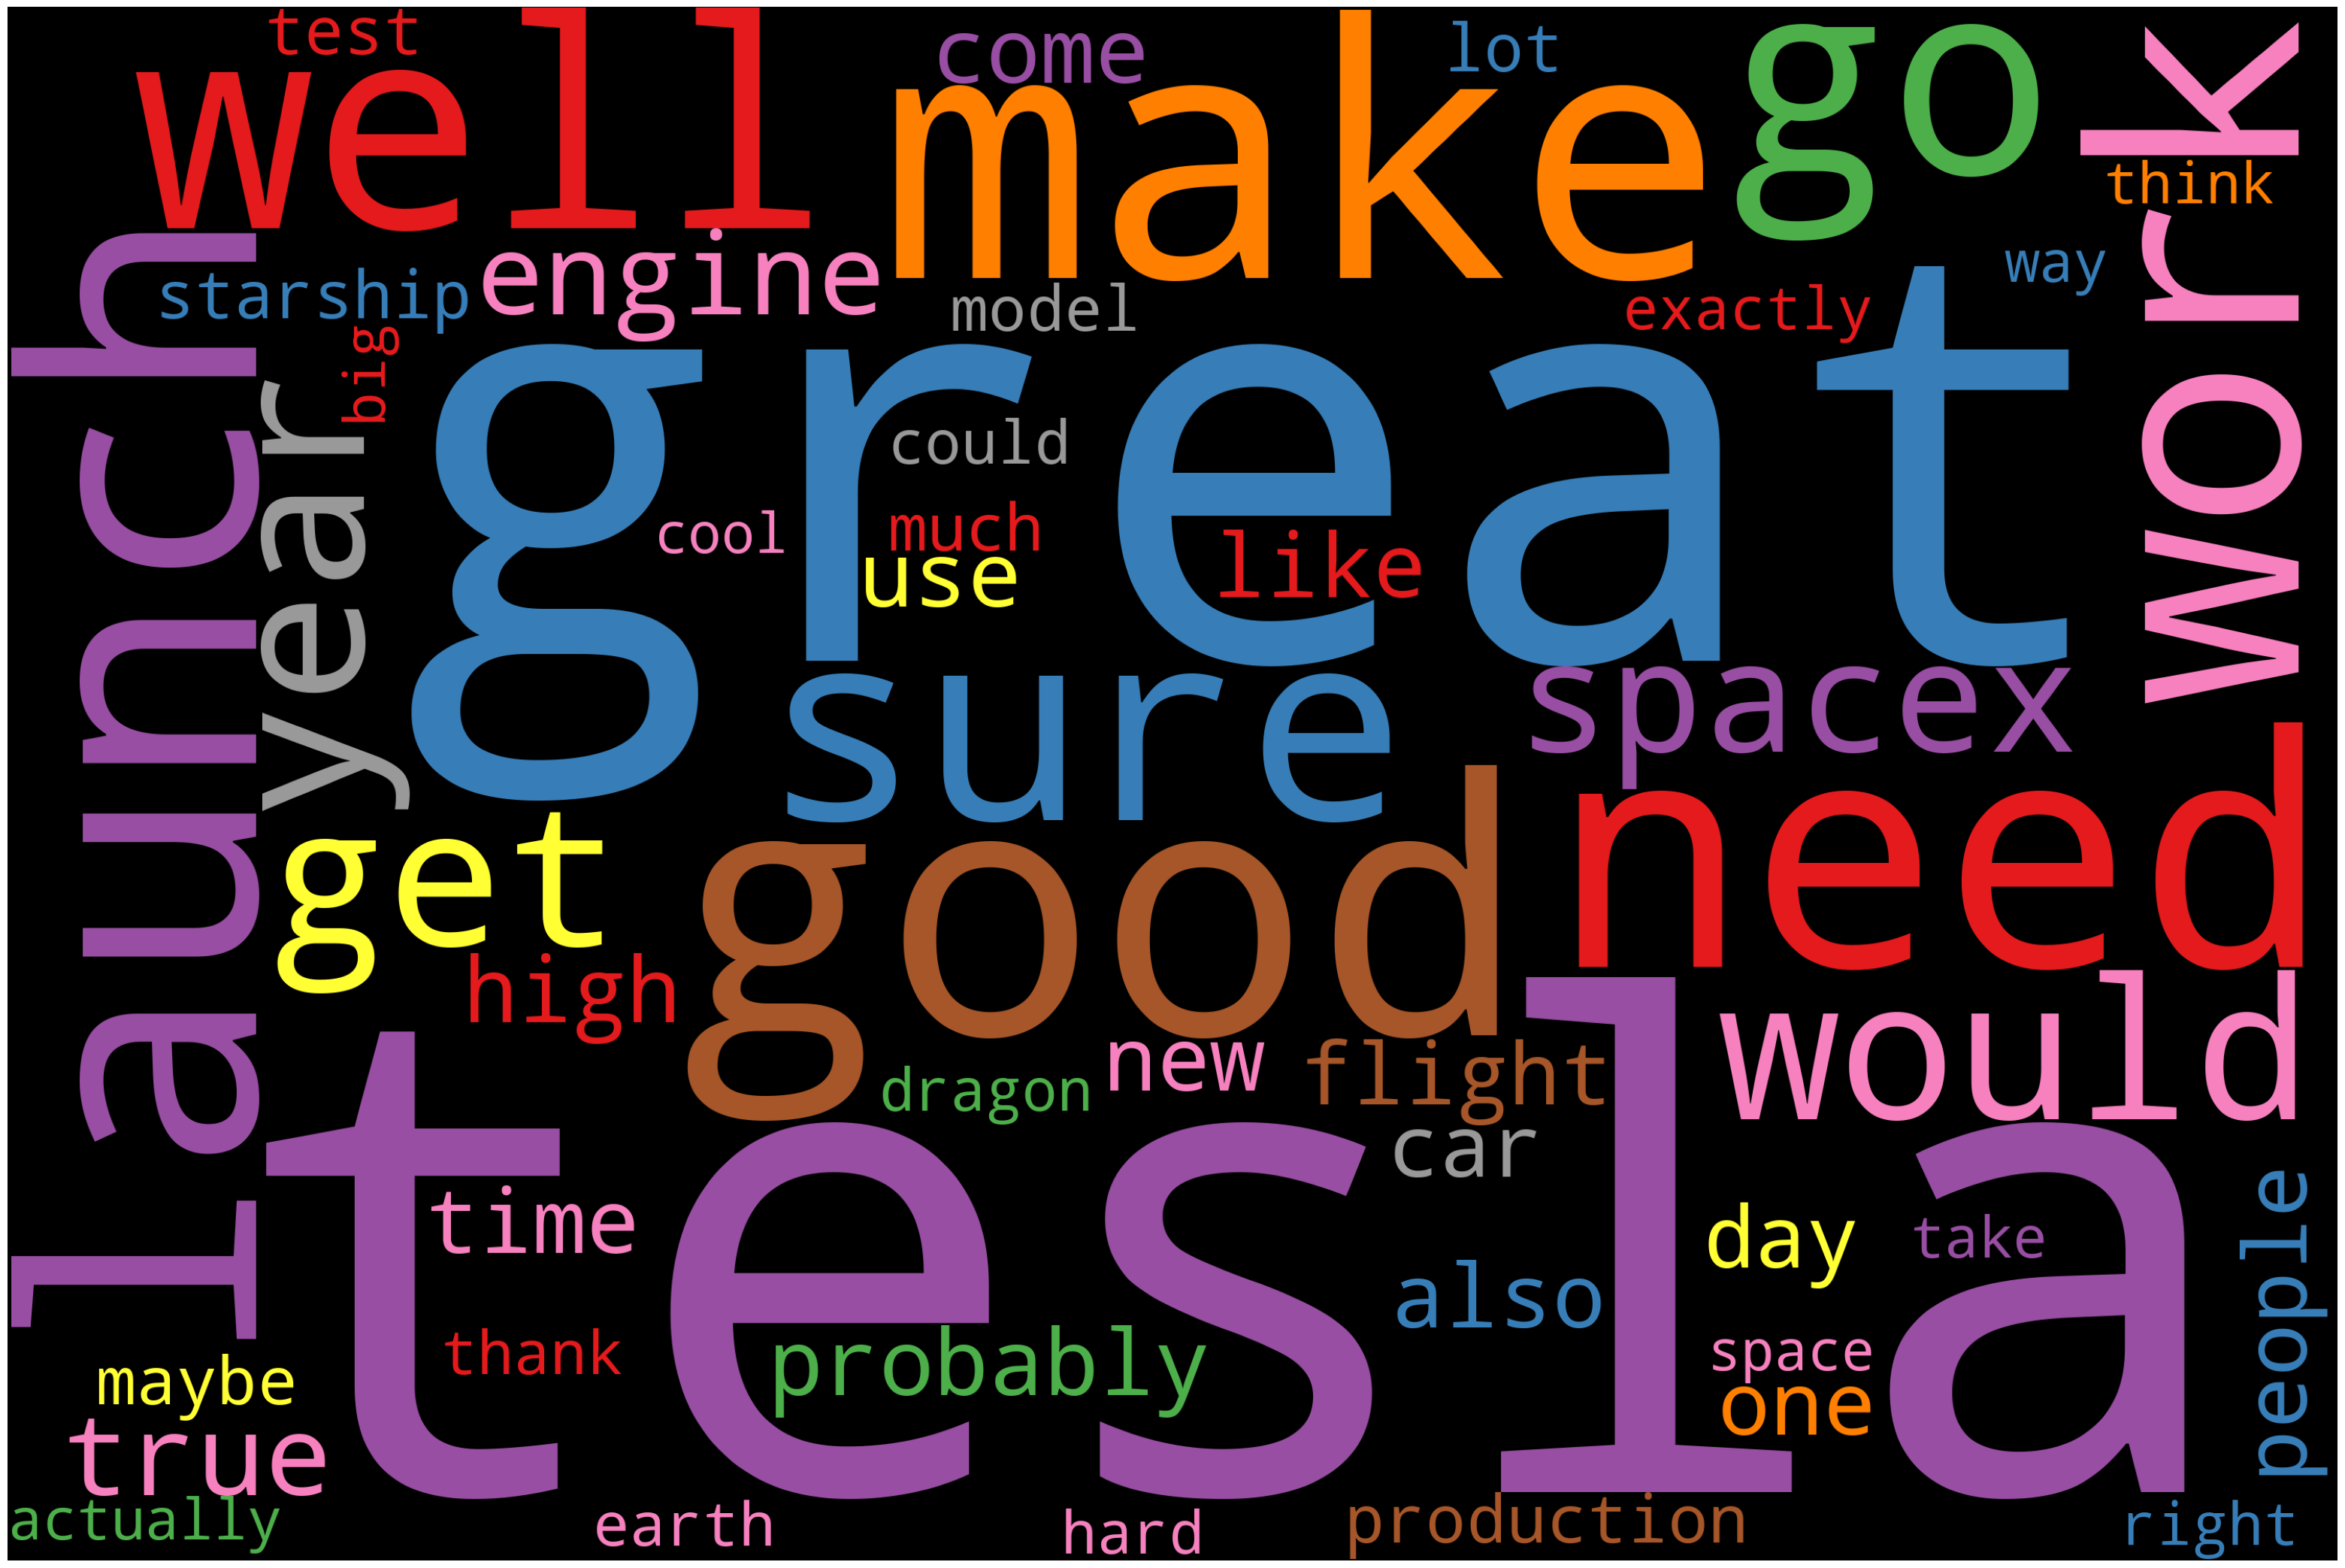

In [33]:
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    plt.figure(figsize=(40,30))
    plt.imshow(wordcloud)
    plt.axis('off')
    
# Generate Word Cloud

#STOPWORDS.add('pron')
#STOPWORDS.add('rt')
#STOPWORDS.add('yeah')
wordcloud=WordCloud(width=3000,height=2000,background_color='black',max_words=50,
                   colormap='Set1',stopwords=my_stop_words).generate(clean_tweets)
plot_cloud(wordcloud)

In [55]:
import re
import string
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Step 1: Removing '@names'
def remove_pattern(text, pattern_regex):
    r = re.findall(pattern_regex, text)
    for i in r:
        text = re.sub(i, '', text)
    return text 
# Assuming tweets is a list
tweets = pd.DataFrame(tweets, columns=['Tweets'])

# Now you can proceed with the preprocessing steps

tweets['Tidy_Tweets'] = np.vectorize(remove_pattern)(tweets['Tweets'], "@[\w]*")


In [56]:

# Step 2: Removing links (http | https)
cleaned_tweets = []

for index, row in tweets.iterrows():
    words_without_links = [word for word in row.Tidy_Tweets.split() if 'http' not in word]
    cleaned_tweets.append(' '.join(words_without_links))

tweets['Tidy_Tweets'] = cleaned_tweets

In [57]:

# Step 3: Removing tweets with empty text
tweets = tweets[tweets['Tidy_Tweets']!='']


In [58]:

# Step 4: Dropping duplicate rows
tweets.drop_duplicates(subset=['Tidy_Tweets'], keep=False, inplace=True)



In [59]:
# Step 5: Resetting index
tweets = tweets.reset_index(drop=True)


In [60]:

# Step 6: Removing Punctuations, Numbers, and Special characters
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

tweets['Tidy_Tweets'] = tweets['Tidy_Tweets'].apply(lambda x: clean_text(x))



In [61]:
# Step 7: Removing emoji
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

tweets['Tidy_Tweets'] = tweets['Tidy_Tweets'].apply(lambda x: remove_emoji(x))



In [62]:
# Step 8: Tokenize 'absolute_tidy_tweets'
from nltk.tokenize import word_tokenize
tweets['tokenized_tweets'] = tweets['Tidy_Tweets'].apply(lambda x: word_tokenize(x))



In [63]:
# Step 9: Removing Stop words
my_stop_words = stopwords.words('english')
sw_list = ['i’m','\x92','rt','ye','yeah','haha','Yes','U0001F923','I','U0001F3B6','U0001F5A4']
my_stop_words.extend(sw_list)
stopwords_set = set(my_stop_words)

cleaned_tweets = []

for index, row in tweets.iterrows():
    words_without_stopwords = [word for word in row.Tidy_Tweets.split() if not word in stopwords_set and '#' not in word.lower()]
    cleaned_tweets.append(' '.join(words_without_stopwords))
    
tweets['absolute_tidy_tweets'] = cleaned_tweets


In [64]:

# Step 10: Converting words to Lemma
word_lemmatizer = WordNetLemmatizer()

tweets['absolute_tidy_tweets'] = tweets['absolute_tidy_tweets'].apply(lambda x: [word_lemmatizer.lemmatize(word) for word in x.split()])


In [65]:

# Step 11: Joining all tokens into sentences
tweets['absolute_tidy_tweets'] = tweets['absolute_tidy_tweets'].apply(lambda x: ' '.join(x))

tweets.head(10)


,Tweets,Tidy_Tweets,tokenized_tweets,absolute_tidy_tweets
0,@kunalb11 Im an alien,im an alien,"[im, an, alien]",im alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,ray tracing on cyberpunk with hdr is nextlevel...,"[ray, tracing, on, cyberpunk, with, hdr, is, n...",ray tracing cyberpunk hdr nextlevel tried
2,@joerogan @Spotify Great interview!,great interview,"[great, interview]",great interview
3,@gtera27 Doge is underestimated,doge is underestimated,"[doge, is, underestimated]",doge underestimated
4,@teslacn Congratulations Tesla China for amazi...,congratulations tesla china for amazing execut...,"[congratulations, tesla, china, for, amazing, ...",congratulation tesla china amazing execution l...
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj,happy new year of the ox,"[happy, new, year, of, the, ox]",happy new year ox
6,"Frodo was the underdoge,\nAll thought he would...",frodo was the underdoge all thought he would f...,"[frodo, was, the, underdoge, all, thought, he,...",frodo underdoge thought would fail
7,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),haha thanks,"[haha, thanks]",thanks
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,indeed tweets definitely do not represent real...,"[indeed, tweets, definitely, do, not, represen...",indeed tweet definitely represent realworld ti...
9,@GiveDirectly Just sent some,just sent some,"[just, sent, some]",sent


In [78]:
from sklearn.feature_extraction.text import CountVectorizer
import spacy
import pandas as pd

cv = CountVectorizer()
tweetscv = cv.fit_transform(lemmas)
print(list(cv.vocabulary_.keys())[109:200])  # Displaying feature names



['spacex', 'need', 'pass', 'deep', 'chasm', 'negative', 'low', 'per', 'ton', 'carbon', 'sequester', 'net', 'value', 'product', 'make', 'must', 'scalable', 'mean', 'price', 'country', 'only', 'difference', 'taxis', 'ship', 'intend', 'earth', 'may', 'idea', 'apply', 'mar', 'xprize', 'team', 'manage', '100', 'capture', 'prize', 'everyone', 'receive', 'stock', 'my', 'comp', 'option', 'take', 'table', 'that', 'miss', 'back', 'work', 'go', 'do', 'appear', 'inflationary', 'meaningfully', 'coin', 'unit', 'whereas', 'wow', 'orbital', 'tower', 'stack', 'enough', 'raptor', 'orbit', 'booster', 'improve', 'mass', 'tonight', 'ðogecoin', 'instructional', 'video', 'people', 'speak', 'so', 'cute', 'u0001f495', 'extremely', 'misleading', 'image', 'reflect', 'rain', 'pain', 'who', 'let', 'hodl', 'rainforest', 'finally', 'come', 'fun', 'its', 'simplicity', 'genius']


In [84]:
# B. CountVectorizer with N-grams (Bigrams & Trigrams)

nlp = spacy.load('en_core_web_sm')
doc_block = nlp(clean_tweets[:1000])
nouns_verbs = [token.text for token in doc_block if token.pos_ in ('NOUN', 'VERB')]
cv = CountVectorizer(max_features=5000, ngram_range=(1, 3))
X = cv.fit_transform(nouns_verbs)
words_freq = [(word, X[:, cv.vocabulary_[word]].sum()) for word in cv.vocabulary_.keys()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
wd_df = pd.DataFrame(words_freq, columns=['word', 'count'])
print(wd_df.head(10))

        word  count
0       year      3
1      thank      2
2       cost      2
3       cash      2
4       flow      2
5   starlink      2
6      trace      1
7  cyberpunk      1
8        hdr      1
9  nextlevel      1


In [85]:
# Creating TF-IDF Vectorizer
tfidf_v = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))
X = tfidf_v.fit_transform(corpus).toarray()

In [90]:
from nltk.corpus import stopwords
ps = PorterStemmer()
corpus = []
for i in tqdm_notebook(range(0, len(tweets))):
    review = re.sub('[^a-zA-Z]', ' ', tweets['absolute_tidy_tweets'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

  0%|          | 0/1660 [00:00<?, ?it/s]

In [91]:
corpus[4]

'congratul tesla china amaz execut last year next even'

In [92]:
## TFidf Vectorizer
tfidf_v=TfidfVectorizer(max_features=5000,ngram_range=(1,3))
X=tfidf_v.fit_transform(corpus).toarray()

In [93]:
X.shape

(1660, 5000)

In [95]:
# Accessing feature names from TfidfVectorizer
tfidf_v = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))
X = tfidf_v.fit_transform(corpus).toarray()
feature_names = tfidf_v.get_feature_names_out()
print(feature_names[:20])


['aber' 'abl' 'abort' 'absolut' 'absurd' 'acceler' 'accept' 'access'
 'accur' 'achiev' 'across' 'activ' 'actual' 'ad' 'add' 'address' 'advanc'
 'advantag' 'africa' 'age']


In [96]:
tfidf_v.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 5000,
 'min_df': 1,
 'ngram_range': (1, 3),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [99]:
# Create DataFrame with TF-IDF values
count_df = pd.DataFrame(X, columns=tfidf_v.get_feature_names_out())
count_df.head()


,aber,abl,abort,absolut,absurd,acceler,accept,access,accur,achiev,...,year get,year support,year sure,yesterday,yet,yup,zero,zero death,zero death oct,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:

# C. TF-IDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_v = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))
X = tfidf_v.fit_transform(corpus).toarray()
count_df = pd.DataFrame(X, columns=tfidf_v.get_feature_names_out())
count_df.head()


,aber,abl,abort,absolut,absurd,acceler,accept,access,accur,achiev,...,year get,year support,year sure,yesterday,yet,yup,zero,zero death,zero death oct,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:
# Filtering the nouns and verbs only
one_block=clean_tweets
doc_block=nlp(one_block)
nouns_verbs=[token.text for token in doc_block if token.pos_ in ('NOUN','VERB')]
print(nouns_verbs[100:200])

['time', 'launch', 'tower', 'stack', 'raptor', 'orbit', 'booster', 'improve', 'ship', 'booster', 'mass', 'back', 'work', 'tonight', 'video', 'people', 'speak', 'cute', 'image', 'reflect', 'time', 'cost', 'people', 'rain', 'pain', 'let', 'doge', 'rainforest', 'come', 'crypto', 'simplicity', 'genius', 'decade', 'work', 'look', 'note', 'email', 'text', 'lesson', 'learn', 'earth', 'time', 'tell', 'story', 'tesla', 'read', 'kingdom', 'hear', 'name', 'year', 'dogecake', 'thing', 'restaurant', 'hang', 'currency', 'earth', 'scratch', 'destiny', 'franz', 'say', 'ship', 'landing', 'burn', 'solution', 'greate', 'use', 'gas', 'maneuvering', 'rcs', 'thruster', 'seem', 'raptor', 'launch', 'mission', 'collect', 'datum', 'galaxy', 'explore', 'launch', 'starlink', 'satellite', 'orbit', 'mission', 'pad', '39a', 'deck', 'default', 'engine', 'lever', 'arm', 'shut', 'engine', 'min', 'throttle', 'point', 'flameout', 'risk', 'start', 'engine', 'shut']


In [103]:
# Counting the noun & verb tokens
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer()

X=cv.fit_transform(nouns_verbs)
sum_words=X.sum(axis=0)

words_freq=[(word,sum_words[0,idx]) for word,idx in cv.vocabulary_.items()]
words_freq=sorted(words_freq, key=lambda x: x[1], reverse=True)

wd_df=pd.DataFrame(words_freq)
wd_df.columns=['word','count']
wd_df[0:10] # viewing top ten results

,word,count
0,tesla,76
1,make,64
2,launch,62
3,year,49
4,work,49
5,need,48
6,go,43
7,come,42
8,get,38
9,day,38


<Axes: title={'center': 'Top 10 nouns and verbs'}, xlabel='word'>

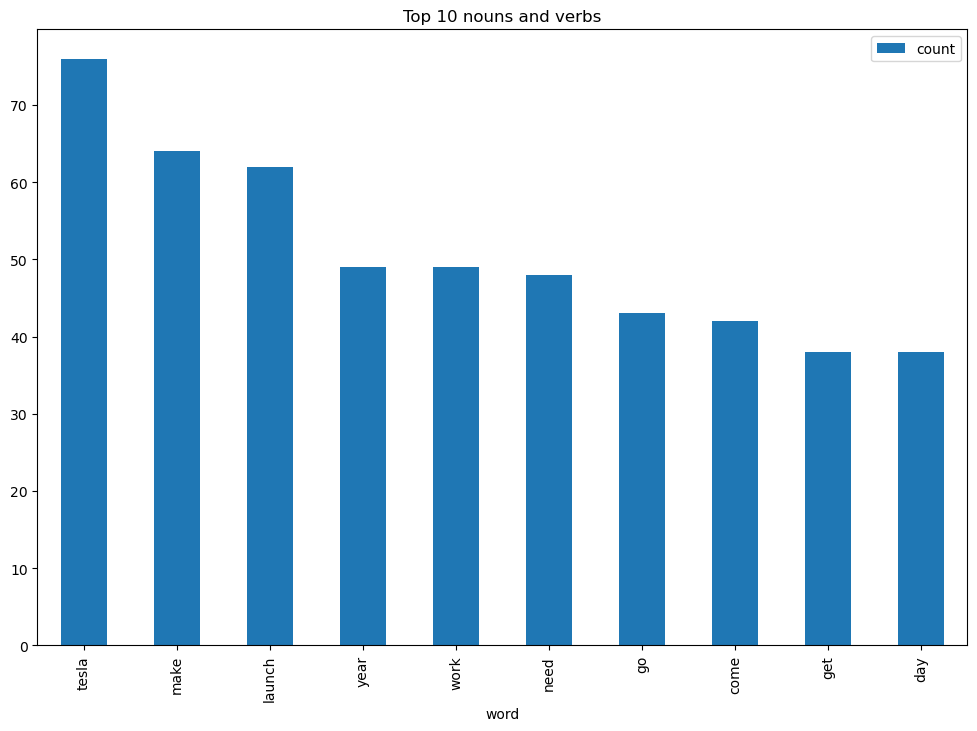

In [104]:
# Visualizing results (Barchart for top 10 nouns + verbs)
wd_df[0:10].plot.bar(x='word',figsize=(12,8),title='Top 10 nouns and verbs')

In [105]:
# BOW features
bow_word_vectorizer = CountVectorizer(max_df=0.90, min_df=2, stop_words='english')
# bag-of-words feature matrix
bow_word_feature = bow_word_vectorizer.fit_transform(tweets['absolute_tidy_tweets'])

# TF-IDF features
tfidf_word_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, stop_words='english')
# TF-IDF feature matrix
tfidf_word_feature = tfidf_word_vectorizer.fit_transform(tweets['absolute_tidy_tweets'])

In [106]:
tweets

,Tweets,Tidy_Tweets,tokenized_tweets,absolute_tidy_tweets
0,@kunalb11 Im an alien,im an alien,"[im, an, alien]",im alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,ray tracing on cyberpunk with hdr is nextlevel...,"[ray, tracing, on, cyberpunk, with, hdr, is, n...",ray tracing cyberpunk hdr nextlevel tried
2,@joerogan @Spotify Great interview!,great interview,"[great, interview]",great interview
3,@gtera27 Doge is underestimated,doge is underestimated,"[doge, is, underestimated]",doge underestimated
4,@teslacn Congratulations Tesla China for amazi...,congratulations tesla china for amazing execut...,"[congratulations, tesla, china, for, amazing, ...",congratulation tesla china amazing execution l...
...,...,...,...,...
1655,"@flcnhvy True, it sounds so surreal, but the n...",true it sounds so surreal but the negative pro...,"[true, it, sounds, so, surreal, but, the, nega...",true sound surreal negative propaganda still a...
1656,@PPathole Make sure to read ur terms &amp; con...,make sure to read ur terms amp conditions befo...,"[make, sure, to, read, ur, terms, amp, conditi...",make sure read ur term amp condition clicking ...
1657,@TeslaGong @PPathole Samwise Gamgee,samwise gamgee,"[samwise, gamgee]",samwise gamgee
1658,@PPathole Altho Dumb and Dumber is <U+0001F525...,altho dumb and dumber is,"[altho, dumb, and, dumber, is]",altho dumb dumber


# Fetch sentiments

In [107]:
# 1 way
def fetch_sentiment_using_SIA(text):
    sid = SentimentIntensityAnalyzer()
    polarity_scores = sid.polarity_scores(text)
    return 'neg' if polarity_scores['neg'] > polarity_scores['pos'] else 'pos'

# 2 way
def fetch_sentiment_using_textblob(text):
    analysis = TextBlob(text)
    return 'pos' if analysis.sentiment.polarity >= 0 else 'neg'

In [109]:
sentiments_using_SIA = tweets.absolute_tidy_tweets.apply(lambda tweet: fetch_sentiment_using_SIA(tweet))
pd.DataFrame(sentiments_using_SIA.value_counts())

,absolute_tidy_tweets
pos,1461
neg,199


In [110]:
tweets.Tidy_Tweets[3]

'doge is underestimated'

In [111]:
sid = SentimentIntensityAnalyzer()
sid.polarity_scores(tweets.absolute_tidy_tweets[3])

{'neg': 0.677, 'neu': 0.323, 'pos': 0.0, 'compound': -0.2732}

In [112]:
df=pd.DataFrame()
df['Tweets'] = tweets.absolute_tidy_tweets
df['scores'] = tweets['Tidy_Tweets'].apply(lambda review: sid.polarity_scores(review))
df.head()

,Tweets,scores
0,im alien,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,ray tracing cyberpunk hdr nextlevel tried,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2,great interview,"{'neg': 0.0, 'neu': 0.196, 'pos': 0.804, 'comp..."
3,doge underestimated,"{'neg': 0.512, 'neu': 0.488, 'pos': 0.0, 'comp..."
4,congratulation tesla china amazing execution l...,"{'neg': 0.0, 'neu': 0.645, 'pos': 0.355, 'comp..."


In [113]:
df['compound']  = df['scores'].apply(lambda scores: scores['compound'])
df.head()

,Tweets,scores,compound
0,im alien,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
1,ray tracing cyberpunk hdr nextlevel tried,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
2,great interview,"{'neg': 0.0, 'neu': 0.196, 'pos': 0.804, 'comp...",0.6249
3,doge underestimated,"{'neg': 0.512, 'neu': 0.488, 'pos': 0.0, 'comp...",-0.2732
4,congratulation tesla china amazing execution l...,"{'neg': 0.0, 'neu': 0.645, 'pos': 0.355, 'comp...",0.8271


In [114]:
df['compound']  = df['scores'].apply(lambda scores: scores['compound'])
df.head()

,Tweets,scores,compound
0,im alien,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
1,ray tracing cyberpunk hdr nextlevel tried,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
2,great interview,"{'neg': 0.0, 'neu': 0.196, 'pos': 0.804, 'comp...",0.6249
3,doge underestimated,"{'neg': 0.512, 'neu': 0.488, 'pos': 0.0, 'comp...",-0.2732
4,congratulation tesla china amazing execution l...,"{'neg': 0.0, 'neu': 0.645, 'pos': 0.355, 'comp...",0.8271


In [115]:
tweets.describe()

,Tweets,Tidy_Tweets,tokenized_tweets,absolute_tidy_tweets
count,1660,1660,1660,1660
unique,1660,1627,1622,1601
top,@kunalb11 Im an alien,,[],
freq,1,27,34,43


In [138]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import seaborn as sns

In [137]:
# Load the dataset
df = pd.read_csv("C:\\Users\\chakri\\Downloads\\Elon_musk.csv", encoding='latin1')


In [139]:

# Tokenization, remove stopwords, and lemmatization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


In [140]:

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha() and token not in stop_words]
    return ' '.join(tokens)


In [141]:

df['clean_text'] = df['Text'].apply(preprocess_text)



In [142]:
# Sentiment Analysis
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

df['sentiment'] = df['clean_text'].apply(get_sentiment)



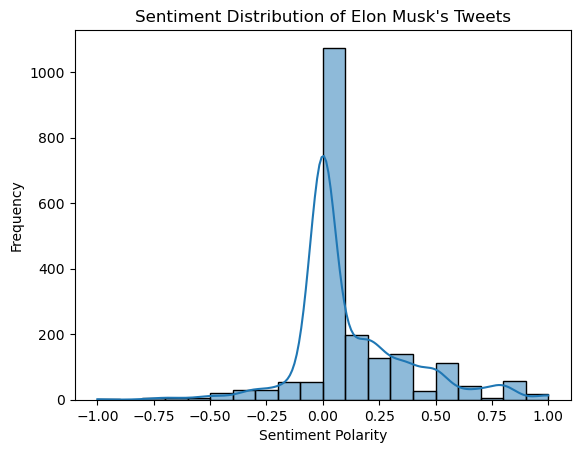

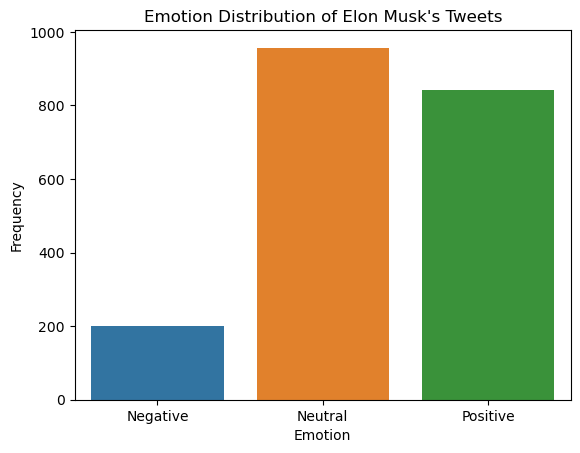

In [147]:
# Emotion Mining
def get_emotion(polarity):
    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

df['emotion'] = df['sentiment'].apply(get_emotion)

# Visualize sentiment distribution
sns.histplot(df['sentiment'], bins=20, kde=True)
plt.title('Sentiment Distribution of Elon Musk\'s Tweets')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

# Visualize emotion distribution
sns.countplot(data=df, x='emotion')
plt.title('Emotion Distribution of Elon Musk\'s Tweets')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.show()


In [154]:
# Importing necessary libraries
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd

# Define functions for sentiment analysis using SIA
def fetch_sentiment_using_SIA(text):
    sid = SentimentIntensityAnalyzer()
    polarity_scores = sid.polarity_scores(text)
    return 'neg' if polarity_scores['neg'] > polarity_scores['pos'] else 'pos'

# Applying sentiment analysis using SIA to the tweets
sentiments_using_SIA = tweets['absolute_tidy_tweets'].apply(fetch_sentiment_using_SIA)

# Creating a DataFrame to display the sentiment distribution
sentiments_df = pd.DataFrame(sentiments_using_SIA.value_counts())

# Displaying the sentiment distribution
print(sentiments_df)


     absolute_tidy_tweets
pos                  1461
neg                   199


In [162]:
import re
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

# A. Most common words in positive tweets
def generate_wordcloud(all_words):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2').generate(all_words)

    plt.figure(figsize=(14, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()


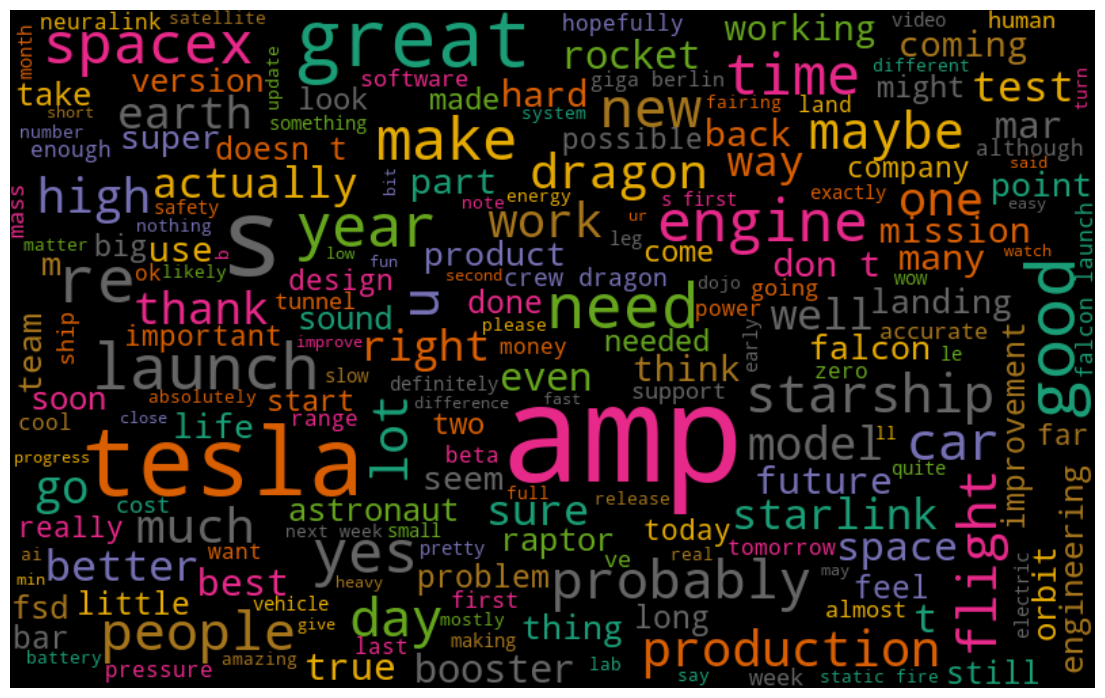

In [160]:

# Concatenate all positive tweets
positive_tweets = ' '.join([text for text in tweets['absolute_tidy_tweets']])
generate_wordcloud(positive_tweets)


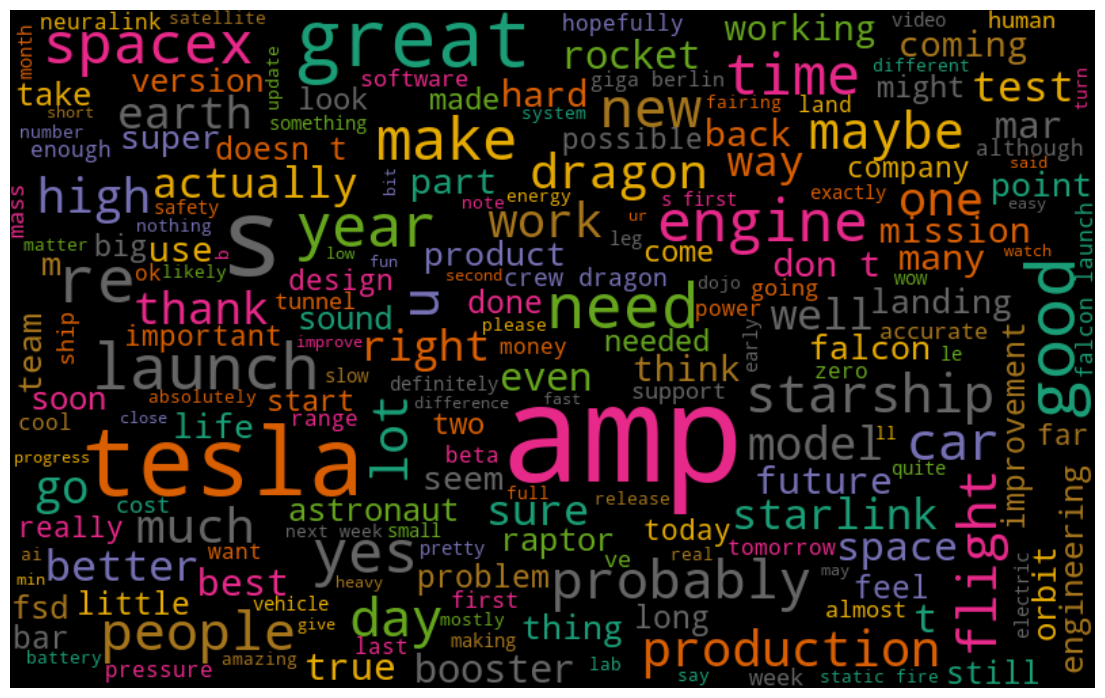

In [159]:

# B. Most common words in negative tweets
negative_tweets = ' '.join([text for text in tweets['absolute_tidy_tweets']])
generate_wordcloud(negative_tweets)

